# Comp Screening - cell painting GT (OG316) analysis
## FOR COMPLTETE (datalock) cell painting dataset
#### _BEM 10-10-2021_

### What this does: Analysis of GT screen with full perturbation library of 316 drugs (OG316)
- Loads in anndata file of harmonized GT data, adds in appropriate metadata
- Calculates UMAP 
- Calculates Mahalanobis distance of each perturbation replicate from DMSO
    - Calls significant perturbations as those that have Mahalan. distance > mean(Mahala. distances) + std(Mahala. distances)
- Identifying clusters of perturbations
    - Runs louivan clustering over the samples with resolution scaninng to choose best clustering resolution
        - This defines GT cellular phenotypes
        - Runs enrichment tests to identify types of cell painting features enriched in each phenotype
    - For each drug,
        - Runs enrichment tests to see if the replicates from the drug are enriched in any given phenotype
    - Clusters drugs over the enrichment scores identified in the above step
        - This defines the GT drug clusters

In [10]:
import os
import sys
import warnings
import random
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import anndata
import multiprocess as mp
from itertools import repeat
from scipy.stats import mode
from scipy.stats import fisher_exact
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.covariance import EmpiricalCovariance
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.multitest import multipletests

pd.set_option('mode.chained_assignment', None)
data_path = '/Users/connerkummerlowe/Dropbox (MIT)/lets_do_drugs/BEM/Manu_analysis/1_Data/'

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica"

## Define Functions

#### Hide annoying prints

In [2]:
class HiddenPrints:
    """
    Class to hide unnecessary prints
    """
    
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

#### Mahalanobis calcs

In [3]:
def mahala_dist(adata, use_rep='X', mahala_cutoff=2, n_sample=int(1e6), assume_centered=False, num_pcs=None):
    """
    Calculates the mahalanobis disance of the pert. avg and provides a standard deviation cutoff based on DMSO null dist
    in adata using MCD robust estimator trained on DMSO + avg Pert., stores values as metadata
    """
    
    # weight PCs by variance explained
    adata.obsm['X_pca_weighted'] = np.multiply(adata.obsm['X_pca'],adata.uns['pca']['variance_ratio'])
    adata.obsm['X_pca_harmony_weighted'] = np.multiply(adata.obsm['X_pca_harmony'],adata.uns['pca']['variance_ratio'])
    
    # select data
    adata_DMSO = adata[adata.obs.Metadata_perturbation=='DMSO',:]
    adata_pert = adata[~(adata.obs.Metadata_perturbation=='DMSO'),:]
    
    if use_rep == 'X':
        X_DMSO = adata_DMSO.X
        X_pert = pd.DataFrame(adata_pert.X, 
                              index=adata_pert.obs['Metadata_perturbation'])

    elif use_rep == 'X_pca':
        if num_pcs == None:
            print('speficy num_pcs')
            return
        else:
            X_DMSO = adata_DMSO.obsm['X_pca_weighted'][:,0:num_pcs]
            X_pert = pd.DataFrame(adata_pert.obsm['X_pca_weighted'][:,0:num_pcs], 
                                  index=adata_pert.obs['Metadata_perturbation'])
            
    elif use_rep == 'X_pca_harmony':
        if num_pcs == None:
            print('speficy num_pcs')
            return
        else:
            X_DMSO = adata_DMSO.obsm['X_pca_harmony_weighted'][:,0:num_pcs]
            X_pert = pd.DataFrame(adata_pert.obsm['X_pca_harmony_weighted'][:,0:num_pcs], 
                                  index=adata_pert.obs['Metadata_perturbation'])
    
    else:
        print('use_rep is not valid option')
        return
    
    # average by perturbation
    X_avg_pert = X_pert.groupby('Metadata_perturbation').mean()

    # fit covariance estimator to control + avg. pert. sample
    cov = EmpiricalCovariance(assume_centered=assume_centered).fit(X_DMSO)
    
    # calclute perturbation mahalanois distances
    if assume_centered:
        pert_mahal = np.sqrt(cov.mahalanobis(X_avg_pert))
    else:
        pert_mahal = np.sqrt(cov.mahalanobis(X_avg_pert-cov.location_))
    
    # sample DMSO null distribution
    n_rep = mode(X_pert.iloc[:,0].groupby('Metadata_perturbation').count()).mode[0]
    n_DMSO = len(X_DMSO)
    DMSO_null = np.mean(X_DMSO[np.random.randint(0,n_DMSO,size=(n_sample,n_rep))], axis=1)
    
    #calc DMSO null mahalanobis
    if assume_centered:
        DMSO_mahal = np.sqrt(cov.mahalanobis(DMSO_null))
    else:
        DMSO_mahal = np.sqrt(cov.mahalanobis(DMSO_null-cov.location_))
            
    # build pert table
    # get cutoff based on multiples of perturbation stdev
    mahala_cutoff = (mahala_cutoff*np.std(pert_mahal))+np.mean(pert_mahal)
    
    mahala_table = pd.DataFrame(pert_mahal, 
                                index=X_avg_pert.index,
                                columns=['mahalanobis'])
    mahala_table['signif_mahala'] = (pert_mahal > mahala_cutoff)
    mahala_table.reset_index(inplace=True)
    
    # add back to adata
    merge_table = pd.DataFrame(adata.obs.Metadata_perturbation).merge(mahala_table, 
                                                                      on='Metadata_perturbation', 
                                                                      how='left')
    merge_table = merge_table.set_index('Metadata_perturbation').reset_index(drop=True)
    
    with HiddenPrints():
        adata.obs['mahalanobis'] = merge_table.mahalanobis.values
        adata.obs['signif_mahala'] = merge_table.signif_mahala.values
    
    # make mahala table for plotting    
    dmso_table = pd.DataFrame(np.random.choice(DMSO_mahal, size=n_DMSO, replace=False),
                              columns=['mahalanobis'])
    dmso_table['Metadata_perturbation'] = 'DMSO'
    dmso_table['signif_mahala'] = 'DMSO'
    
    mahala_table = pd.concat([mahala_table, dmso_table])
    
    return adata, mahala_table

#### Fingerprint enrichments

In [4]:
def pull_Cluster_adata(adata):
    """
    pulls out perturbation clustering from adata
    """
    return adata.obs.loc[:,adata.obs.columns.isin(['Metadata_perturbation','leiden'])]

def fingerprint_shuffle_helper(run,cluster_table,perturb_count_table):
    resampled_clusters = np.random.choice(cluster_table.leiden.values,size=cluster_table.shape[0],replace=False)
    resampled_crosstab = pd.crosstab(cluster_table.Metadata_perturbation,resampled_clusters,dropna=False)
    
    # transform counts to perturbation abundance within each cluster
    row_sum = resampled_crosstab.sum(axis=1)
    resampled_crosstab = resampled_crosstab.div(row_sum, axis=0)
    
    # Z-score tranform abundance within each cluster
    col_mean = resampled_crosstab.mean(axis=0)
    col_std = resampled_crosstab.std(axis=0)
    resampled_crosstab = resampled_crosstab.sub(col_mean, axis=1).div(col_std, axis=1)
    
    return (resampled_crosstab > perturb_count_table).astype(int)
    
def fingerprint_shuffle_test(adata,num_shuffle=10000):
    
    cluster_table = pull_Cluster_adata(adata)
    
    perturb_count_table = pd.crosstab(cluster_table.Metadata_perturbation,cluster_table.leiden,dropna=False)
    
    count_table = np.array(perturb_count_table)

    # transform counts to perturbation abundance within each cluster
    row_sum = perturb_count_table.sum(axis=1)
    perturb_count_table = perturb_count_table.div(row_sum, axis=0)
    
    # Z-score tranform abundance within each cluster
    col_mean = perturb_count_table.mean(axis=0)
    col_std = perturb_count_table.std(axis=0)
    perturb_count_table = perturb_count_table.sub(col_mean, axis=1).div(col_std, axis=1)

    # shuffle cluster assignments to compute p-val
    if num_shuffle > (mp.cpu_count()-1):
        p_size = (mp.cpu_count()-1)
    else:
        p_size = 1
        
    runs = list(range(num_shuffle))
    pool = mp.Pool(p_size)
    
    pval = sum(pool.starmap(fingerprint_shuffle_helper, 
                            zip(runs,repeat(cluster_table),repeat(np.array(perturb_count_table)))))
    pool.close()
    pool.join()
    
    edata = anndata.AnnData(X = perturb_count_table.reset_index(drop=True))
    edata.obs['Metadata_perturbation'] = perturb_count_table.index.values
    edata.obsm['count_table'] = count_table
    edata.obsm['pval'] = np.array(pval)/num_shuffle
    
    # add info for maximum z-score for each compound
    pert_max_col = np.argmax(edata.X, axis=1)

    max_pheno = []
    max_zs = []
    max_pval = []

    row=0
    for i in pert_max_col:
        max_pheno.append(edata.var_names[i])
        max_zs.append(edata.X[row,i])
        max_pval.append(edata.obsm['pval'][row,i])
        row+=1

    edata.obs['max_phenotype'] = max_pheno
    edata.obs['max_zs'] = max_zs
    edata.obs['max_pval'] = max_pval
    edata.obs['-log10(max_pval)'] = np.nan_to_num(-np.log10(max_pval), posinf=-np.log10(1/(10*num_shuffle)))
    
    return edata

In [5]:
### Map fingerprint clustering back to anndata object

def fingers_to_adata(orig_adata, fingerprint_adata):

    sig_clusts = list(set(fingerprint_adata.obs.leiden.values))+['DMSO']

    sig_df = pd.DataFrame(columns = sig_clusts)

    for sig in sig_clusts:

        if sig=='DMSO':
            sig_df[sig] = (orig_adata.obs.Metadata_perturbation == sig)
            sig_df[sig] = orig_adata.obs.Metadata_perturbation[(orig_adata.obs.Metadata_perturbation == sig)]

        else:
            i_clust_drugs = list(set(fingerprint_adata.obs.loc[fingerprint_adata.obs.leiden==sig,'Metadata_perturbation']))
            sig_df[sig] = (orig_adata.obs.Metadata_perturbation.isin(i_clust_drugs))
            sig_df[sig] = np.where(sig_df[sig], sig, np.nan)

    sig_df['sig_clusters'] = sig_df.astype(str).replace('nan', '').sum(axis=1)
    sig_df.loc[sig_df.sig_clusters == '', 'sig_clusters'] = np.nan
    sig_df = sig_df.iloc[: , len(sig_clusts):]

    orig_adata.obs['sig_clusters'] = sig_df['sig_clusters']

    return orig_adata

#### Resolution scanning

In [6]:
def res_scan(adata_in, use_rep='X', p_cutoff=0.01, z_cutoff=1.5, res_min=0.1, res_max=2.0, res_num=20, num_shuffle=10000, num_pcs=None):
    """
    Finds the optimal resolution for a feature set by identifying the resolution at which the metrics
    are the highest via scanpy leiden clustering
    """

    # select data
    if use_rep == 'X':
        features = adata_in.X
        
    elif use_rep == 'X_pca':
        if num_pcs == None:
            print('speficy num_pcs')
            return
        else:
            features = adata_in.obsm['X_pca'][:,0:num_pcs]
            
    elif use_rep == 'X_pca_harmony':
        if num_pcs == None:
            print('speficy num_pcs')
            return
        else:
            features = adata_in.obsm['X_pca_harmony'][:,0:num_pcs]  
    
    else:
        print('use_rep is not valid option')
        return
    
    warnings.filterwarnings("ignore") # don't print a bunch of annoying pandas crap
    
    # resolutions to test: defaults to 0.1 to 3.0, by steps of 0.1
    res_scan  = np.linspace(res_min,res_max,num=res_num)

    # Loop through the resolutions and calculate the cluster membership
    silhouette = []
    silhouette_var = []
    num_clust = []
    dmso_clust = []
    ns_clust = []
    dmso_frac = []
    single_sig_frac = []
    multi_sig_frac = []

    for i in range(res_num):

        res = res_scan[i]

        # Run clustering
        adata = adata_in
        
        with HiddenPrints():
            sc.tl.leiden(adata, resolution = res)
            adata.obs.leiden = adata.obs.leiden.astype(int) + 1 
            adata.obs.leiden = adata.obs.leiden.astype('category')
        
        # Calc metrics
        cluster_labels = adata.obs.leiden.values
        sil_avg = silhouette_score(features, cluster_labels)
        sample_silhouette_values = silhouette_samples(features, cluster_labels)
        
        res_sil_var = []
        for i in list(set(cluster_labels)):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, take diff from mean, and avg
            res_sil_var.append(np.mean(np.absolute(sample_silhouette_values[cluster_labels == i]-sil_avg)))
        
        silhouette_var.append(np.mean(res_sil_var))
        silhouette.append(sil_avg)
        num_clust.append(len(set(adata.obs.leiden.values)))
        
        edata = fingerprint_shuffle_test(adata, num_shuffle=num_shuffle)
        dmso_sig = (edata.obsm['pval'][edata.obs.Metadata_perturbation == 'DMSO'] < p_cutoff)
        dmso_count = edata.obsm['count_table'][edata.obs.Metadata_perturbation == 'DMSO']
        pert_sig = (edata.obsm['pval'] < p_cutoff)&(edata.X > z_cutoff)
        
        dmso_clust.append(np.sum(dmso_sig))
        ns_clust.append(np.sum(~np.delete(np.sum(~dmso_sig*pert_sig, axis=0)>0, np.where(dmso_sig))))
        
        dmso_frac.append(np.sum(dmso_sig*dmso_count/np.sum(dmso_count)))
        single_sig_frac.append(np.sum(np.sum(~dmso_sig*pert_sig, axis=1)==1)/np.shape(pert_sig)[0])
        multi_sig_frac.append(np.sum(np.sum(~dmso_sig*pert_sig, axis=1)>1)/np.shape(pert_sig)[0])

    res_table = pd.DataFrame({"resolution":res_scan,
                              "num_clusters":num_clust,
                              "num_DMSO_clusters":dmso_clust,
                              "num_ns_clusters":ns_clust,
                              "mean_silhouette":silhouette,
                              "mean_silhouette_var":silhouette_var,
                              "frac_single_pert_sig":single_sig_frac,
                              "frac_multi_pert_sig":multi_sig_frac,
                              "frac_DMSO_in_DMSO_clust":dmso_frac})
    
    return res_table

#### Feature enrichment plotting

In [7]:
def Feat_enrich_plot(adata_in, file_name, dendro_key = 'harmony_leiden', ref='rest', vmax=3, lfc_cutoff=4):
    """
    for adata run 'rank_genes_groups' retain the n_top_feats plot how each cluster is enriched 
    for that feature set's compartment and channel
    """
    
    adata = adata_in
    
    # figure out what makes the other clusters unique / enriched features
    sc.tl.rank_genes_groups(adata, 'leiden', reference=ref, method='wilcoxon')
    
    # build count table for all feats > lfc
    g_lfc_table = build_count_table(adata, ref='rest', lfc='greater', lfc_cutoff = lfc_cutoff)
    
    # build count table for all feats < lfc
    l_lfc_table = build_count_table(adata, ref='rest', lfc='less', lfc_cutoff = lfc_cutoff)
    
    # calc Fisher's Exact Odds Ratio
    full_table = pd.DataFrame(index=g_lfc_table.index.values,
                              columns=g_lfc_table.columns.values)
    
    for i in list(range(len(full_table.index))):
        
        all_lfc = np.sum(g_lfc_table.iloc[i,:].values)
        all_l_lfc = np.sum(l_lfc_table.iloc[i,:].values)
        
        for c in list(range(len(full_table.columns))):
            cc_lfc = g_lfc_table.iloc[i,c]
            cc_l_lfc = l_lfc_table.iloc[i,c]
            oddsratio, pvalue = fisher_exact([[cc_lfc,(all_lfc-cc_lfc)],[cc_l_lfc,(all_l_lfc-cc_l_lfc)]],
                                             alternative ='greater')
            full_table.iloc[i,c] = -np.log10(pvalue)
            
    # add back to adata
    full_table = full_table.reset_index()
    full_table = full_table.rename(columns={"index":"leiden"})
    merge_table = pd.DataFrame(adata.obs.leiden).merge(full_table,on='leiden', how='left')
    merge_table = merge_table.set_index('leiden').reset_index(drop=True)
    
    with HiddenPrints():
        for col in merge_table.columns.values:
            adata.obs[col] = pd.to_numeric(merge_table[col].values)
    
    # make plots
    channel_dict = {
    'Spatial': ['Cells_AreaShape','Cytoplasm_AreaShape','Nuclei_AreaShape','Cells_Neighbors','Nuclei_Neighbors'],
    'DNA': ['Cells_DNA','Cytoplasm_DNA','Nuclei_DNA'],
    'Mito': ['Cells_Mito','Cytoplasm_Mito','Nuclei_Mito'],
    'Nucleoli': ['Cells_Nucleoli','Cytoplasm_Nucleoli','Nuclei_Nucleoli'],
    'Golgi': ['Cells_Golgi','Cytoplasm_Golgi','Nuclei_Golgi'],
    'ER': ['Cells_ER','Cytoplasm_ER','Nuclei_ER']}
    
    for key in list(channel_dict.keys()):
        channel_dict[key] = list(map(('lfc_'+str(lfc_cutoff)+'_').__add__,channel_dict[key]))
    
    vmin = -np.log10(0.15)
    
    sc.pl.matrixplot(adata, channel_dict, 'leiden',
                     title='log2fc > '+str(lfc_cutoff)+' enriched feats',
                     colorbar_title='Fishers Exact -log(p)',
                     vmin=vmin, vmax=vmax,
                     dendrogram=dendro_key, cmap='magma',
                     save = file_name+"_"+ref+"_"+"lfc_"+str(lfc_cutoff)+"_feat_enrich_plot.pdf")

    sc.pl.matrixplot(adata, channel_dict['DNA'], 'leiden', dendrogram=dendro_key,
                     title='DNA',
                     colorbar_title='Fishers Exact -log(p)',
                     cmap='Blues', 
                     vmin=vmin, vmax=vmax,
                     save = file_name+"_"+ref+"_"+'lfc_'+str(lfc_cutoff)+'DNA.pdf')
                 
    sc.pl.matrixplot(adata, channel_dict['Mito'], 'leiden', dendrogram=dendro_key,
                     title='Mito',
                     colorbar_title='Fishers Exact -log(p)',
                     cmap='Reds', 
                     vmin=vmin, vmax=vmax,
                     save = file_name+"_"+ref+"_"+'lfc_'+str(lfc_cutoff)+'_Mito.pdf')

    sc.pl.matrixplot(adata, channel_dict['Nucleoli'], 'leiden', dendrogram=dendro_key,
                     title='Nucleoli',
                     colorbar_title='Fishers Exact -log(p)',
                     cmap='Greens', 
                     vmin=vmin, vmax=vmax,
                     save = file_name+"_"+ref+"_"+'lfc_'+str(lfc_cutoff)+'_Nucleoli.pdf')

    sc.pl.matrixplot(adata, channel_dict['Golgi'], 'leiden', dendrogram=dendro_key,
                     title='Golgi',
                     colorbar_title='Fishers Exact -log(p)',
                     cmap='Oranges', 
                     vmin=vmin, vmax=vmax,
                     save = file_name+"_"+ref+"_"+'lfc_'+str(lfc_cutoff)+'_Golgi.pdf')

    sc.pl.matrixplot(adata, channel_dict['ER'], 'leiden', dendrogram=dendro_key,
                     title='ER',
                     colorbar_title='Fishers Exact -log(p)',
                     cmap='Purples', 
                     vmin=vmin, vmax=vmax,
                     save = file_name+"_"+ref+"_"+'lfc_'+str(lfc_cutoff)+'_ER.pdf')

    sc.pl.matrixplot(adata, channel_dict['Spatial'], 'leiden', dendrogram=dendro_key,
                     title='Spatial',
                     colorbar_title='Fishers Exact -log(p)',
                     cmap='Greys', 
                     vmin=vmin, vmax=vmax,
                     save = file_name+"_"+ref+"_"+'lfc_'+str(lfc_cutoff)+'_Spatial.pdf')
    
    sc.pl.matrixplot(adata, 'Number_of_Cells', 'leiden', dendrogram=dendro_key,
                     title='Number_of_Cells',
                     colorbar_title='Cells per well',
                     cmap='viridis', 
                     save = file_name+"_"+ref+"_"+'lfc_'+str(lfc_cutoff)+'_Cell_num.pdf')
    
    return adata

def build_count_table(adata, ref='rest', lfc='greater', lfc_cutoff=None):
    
    if ref == 'DMSO':
        clusters = list(set(adata.obs.leiden.values)-{'DMSO'})
    else:
        clusters = list(set(adata.obs.leiden.values))

    full_table = pd.DataFrame()

    for c in clusters:

        if lfc == 'greater':
            enriched_feats = list(adata.uns['rank_genes_groups']['names'][c]\
                                  [adata.uns['rank_genes_groups']['logfoldchanges'][c]>lfc_cutoff])
        
        elif lfc == 'less':
            enriched_feats = list(adata.uns['rank_genes_groups']['names'][c]\
                                  [adata.uns['rank_genes_groups']['logfoldchanges'][c]<=lfc_cutoff])

        enriched_table = adata.var.loc[adata.var.index.isin(enriched_feats)].reset_index().astype(str)
        enriched_table = enriched_table.drop(['measure'], axis=1).groupby(['compartment','channel']).count()
        enriched_table.columns = [c]

        if c == clusters[0]:
            full_table = enriched_table
        else:
            full_table = enriched_table.merge(full_table, how='outer', right_index=True, left_index=True)

    # build counts table
    full_table = full_table.fillna(0)
    full_table = pd.DataFrame(full_table.stack())
    full_table.index = full_table.index.rename(['compartment','channel','leiden'])
    full_table.columns = ['num_feat']
    full_table = full_table.reset_index()
    full_table['label'] = 'lfc_'+str(lfc_cutoff)+'_'+\
                          full_table['compartment'].map(str)+\
                          '_' + full_table['channel'].map(str)
    full_table = full_table.pivot(index='leiden',columns='label',values='num_feat')
    
    return full_table

## Analysis

### Load in anndata

In [11]:
# PCA harmony data
OG316 = anndata.read_h5ad(data_path+'09272021_PCH_rd_OG316_table.h5ad')

# add metadata for landmarks
LM_list = ['DMSO','Doxorubicin','Daunorubicin','Fluvastatin','Ticlopidine',
           'Tropicamide','Mycophenolic Acid','Vinblastine Sulfate','Riluzole']

LM_df = pd.DataFrame(columns = LM_list)

for LM in LM_list:
    LM_df[LM] = (OG316.obs.Metadata_perturbation == LM)
    LM_df[LM] = OG316.obs.Metadata_perturbation[(OG316.obs.Metadata_perturbation == LM)]

    OG316.obs[LM] = LM_df[LM]

OG316.obs['landmarks'] = LM_df.astype(str).replace('nan', '').sum(axis=1)
OG316.obs.loc[OG316.obs.landmarks == '', 'landmarks'] = np.nan

# Add feature descriptors
feature_desc = pd.DataFrame(list(OG316.var_names))[0].str.split('_', n=2, expand=True)
feature_desc.columns = ['compartment','measure','channel']
feature_desc['channel'] = feature_desc.channel.str.split('_', expand=False).str.get(1)

OG316.var['compartment'] = feature_desc.compartment.values
OG316.var['measure'] = feature_desc.measure.values
OG316.var['channel'] = feature_desc.channel.values
OG316.var.loc[OG316.var.channel.isna(), 'channel'] = OG316.var.loc[OG316.var.channel.isna(), 'measure']
digits = ['0','1','2','3','4', '5', '6', '7', '8', '9']
OG316.var.loc[OG316.var.channel.isin(digits), 'channel'] = OG316.var.loc[OG316.var.channel.isin(digits), 'measure']
OG316.var.loc[OG316.var.channel == 'Adjacent', 'channel'] = OG316.var.loc[OG316.var.channel == 'Adjacent', 'measure']

# filter to only ground truth data of 316 compounds
OG316 = OG316[~OG316.obs.Metadata_perturbation.isin(['Auranofin', 'Bortezomib', 'Paclitaxel (Taxol)', 'Vincristine Sulfate']),:]
GT316 = OG316[OG316.obs.Metadata_run.isin(['GT_run2', 'GT_run1_batch1']),:]


### Determine num_PCs, neighbors, UMAP

2022-11-15 09:20:47,039 - harmonypy - INFO - Iteration 1 of 10
2022-11-15 09:20:47,388 - harmonypy - INFO - Iteration 2 of 10
2022-11-15 09:20:47,908 - harmonypy - INFO - Iteration 3 of 10
2022-11-15 09:20:48,277 - harmonypy - INFO - Iteration 4 of 10
2022-11-15 09:20:48,794 - harmonypy - INFO - Iteration 5 of 10
2022-11-15 09:20:49,317 - harmonypy - INFO - Iteration 6 of 10
2022-11-15 09:20:49,734 - harmonypy - INFO - Iteration 7 of 10
2022-11-15 09:20:50,229 - harmonypy - INFO - Iteration 8 of 10
2022-11-15 09:20:50,684 - harmonypy - INFO - Iteration 9 of 10
2022-11-15 09:20:51,071 - harmonypy - INFO - Iteration 10 of 10
2022-11-15 09:20:51,387 - harmonypy - INFO - Converged after 10 iterations


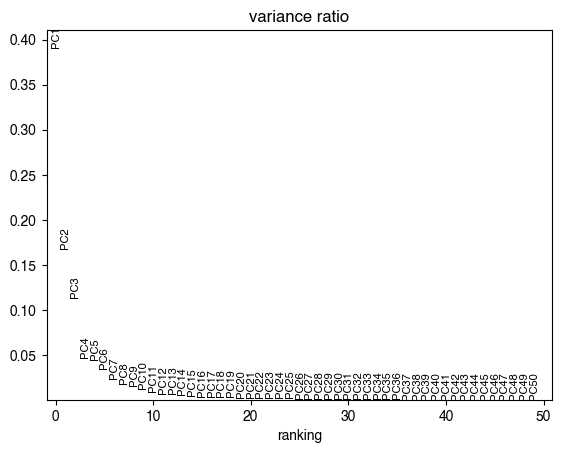

90% of variance explained by 15 PCs


In [12]:
# recalc PC's for dataset
sc.pp.pca(GT316)

# single plate (no need to batch correct)
sc.external.pp.harmony_integrate(GT316, 'Metadata_run')

# get num of PCs to use (up to 90% var explained)
sc.pl.pca_variance_ratio(GT316, n_pcs = 50, log=False)
num_pcs = sum(np.cumsum(GT316.uns['pca']['variance_ratio']) < 0.9)+1

print('90% of variance explained by '+str(num_pcs)+' PCs')

### Determine Signif Pertrubs by Mahalnobis Dist

In [13]:
GT316, mahala_table = mahala_dist(GT316, mahala_cutoff=1, use_rep='X_pca_harmony', num_pcs=num_pcs)

/var/folders/7v/c1jnbc_12kq312b56vlhgmv40000gn/T/ipykernel_88993/1435389131.py:55: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  n_rep = mode(X_pert.iloc[:,0].groupby('Metadata_perturbation').count()).mode[0]


In [ ]:
mahala_table[mahala_table.signif_mahala==True].to_csv('figures/GT_316_sig_mahala.csv')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


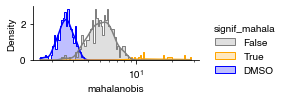

In [77]:
g = sns.displot(data=mahala_table, x="mahalanobis", kde=True, log_scale=10,
                element="step", multiple='layer', stat='density', bins = 100,
                hue="signif_mahala", palette=['grey', 'orange', 'blue'],
                height=1.5, aspect=2)

g.savefig("figures/GT316_mahala_empirical_sig_plot.pdf");

In [12]:
mahala_sig_drugs = set(mahala_table.loc[mahala_table.signif_mahala==True,'Metadata_perturbation'].values)
print(str(len(mahala_sig_drugs))+' significant drugs')

302 significant drugs


### Resolution scanning

In [13]:
sc.pp.neighbors(GT316, n_neighbors=int(np.round(0.5*np.sqrt(np.shape(GT316.X)[0]))), 
                n_pcs=num_pcs, use_rep = 'X_pca_harmony')
sc.tl.umap(GT316)

In [71]:
ms_res_table = res_scan(GT316, use_rep='X_pca_harmony', res_min=0.1, res_max=1.5, res_num=60, num_shuffle=1000, num_pcs=num_pcs)
ms_res_table.to_csv('11232021_OG316_res_scan.csv')

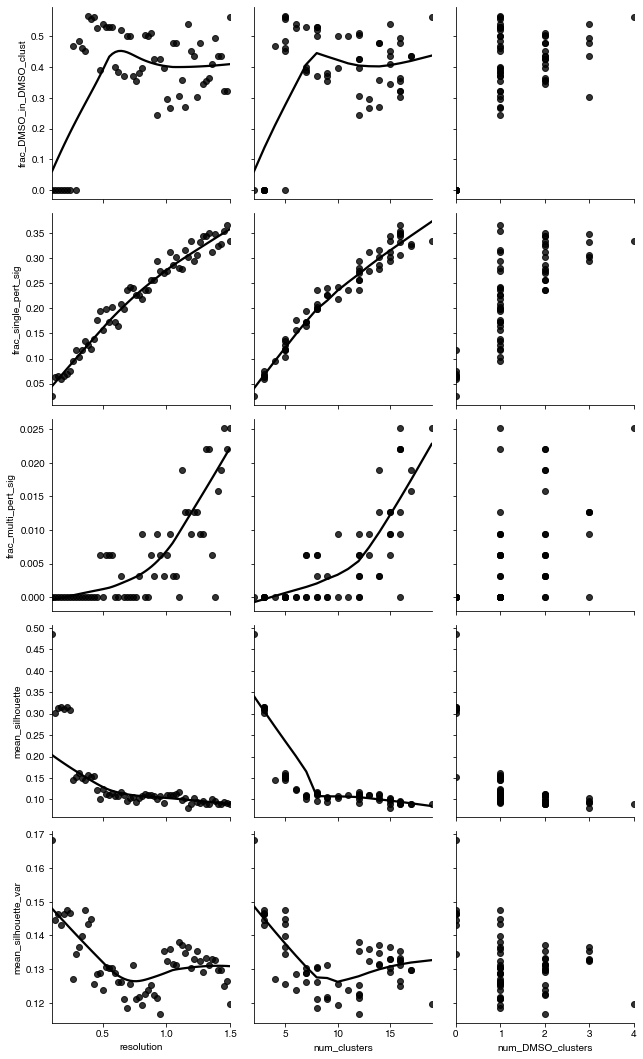

In [72]:
ms_res_table = pd.read_csv('11232021_OG316_res_scan.csv')

g = sns.PairGrid(ms_res_table, y_vars=["frac_DMSO_in_DMSO_clust",'frac_single_pert_sig',
                                       'frac_multi_pert_sig','mean_silhouette','mean_silhouette_var'], 
                 x_vars=["resolution", 'num_clusters', 'num_DMSO_clusters'], height=3)
g.map(sns.regplot, lowess=True, color = 'black')

g.savefig("figures/GT316_res_scan_plot.pdf");

### Plotting @ chosen Resolution

In [25]:
sc.tl.leiden(GT316, resolution = 0.65)
GT316.obs.leiden = GT316.obs.leiden.astype(int) + 1 
GT316.obs.leiden = GT316.obs.leiden.astype('str').astype('category')

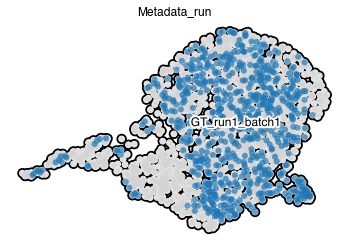

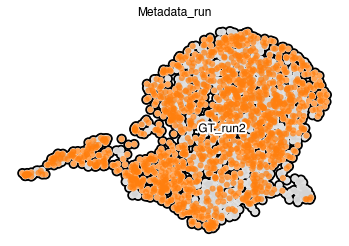

In [26]:
sc.pl.umap(GT316, color='Metadata_run', groups ='GT_run1_batch1', ncols = 1,
           frameon=False, size=150, add_outline=True,
           na_in_legend=False, legend_loc='on data', legend_fontsize=12, legend_fontoutline=4,
           save = 'GT316_UMAP_cell_batch1.pdf')
sc.pl.umap(GT316, color='Metadata_run', groups ='GT_run2', ncols = 1,
           frameon=False, size=150, add_outline=True,
           na_in_legend=False, legend_loc='on data',legend_fontsize=12, legend_fontoutline=4,
           save = 'GT316_UMAP_cell_batch2.pdf')

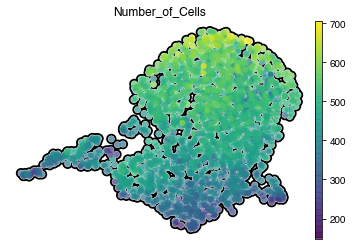

In [27]:
sc.pl.umap(GT316, color=['Number_of_Cells'], ncols = 1,
           frameon=False, size=150, add_outline=True,
           save = 'GT316_UMAP_cell_num.pdf')

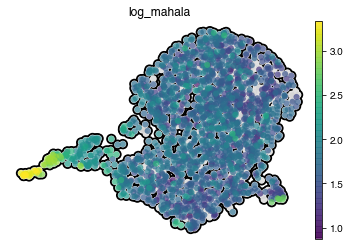

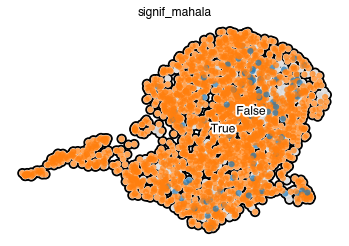

In [28]:
GT316.obs['log_mahala'] = np.log(GT316.obs.mahalanobis.values)
sc.pl.umap(GT316, color=['log_mahala'], ncols = 1, 
           frameon=False, size=150, add_outline=True,
           save = 'GT316_UMAP_log_mahala.pdf')

GT316.obs.signif_mahala = GT316.obs.signif_mahala.astype('category')
sc.pl.umap(GT316, color='signif_mahala', ncols = 1,
           frameon=False, size=150, add_outline=True,
           na_in_legend=False, legend_loc='on data',legend_fontsize=12, legend_fontoutline=4,
           save = 'GT316_UMAP_signif_mahala.pdf')

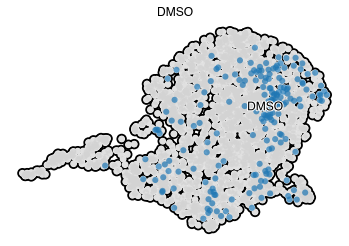

In [29]:
sc.pl.umap(GT316, color='landmarks', groups='DMSO',
           add_outline=True, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2,frameon=False, na_in_legend=False, size=150,
           title='DMSO', palette='tab20', save = 'GT316_UMAP_DMSO.pdf')

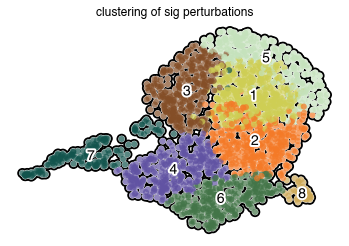

In [30]:
cluster_colors = ['#CECE54','#F47A27','#844E27','#6153A3','#C5E2BC','#437548','#12544D','#CCA754']

sc.pl.umap(GT316, color='leiden', add_outline=True, legend_loc='on data',
           legend_fontsize=14, legend_fontoutline=4,frameon=False, size=150,
           title='clustering of sig perturbations', 
           palette=cluster_colors,
           save = 'GT316_UMAP_leiden.pdf')

categories: 1, 2, 3, etc.
var_group_labels: Spatial, DNA, Mito, etc.


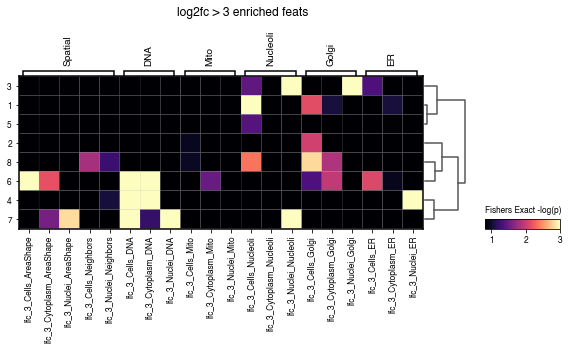

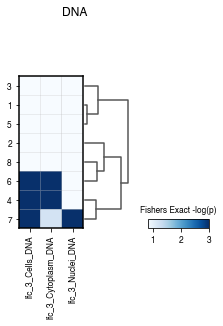

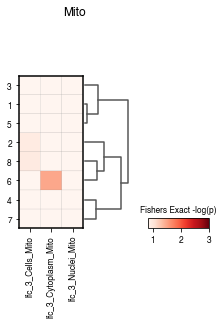

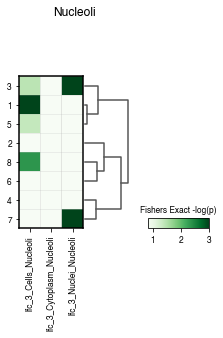

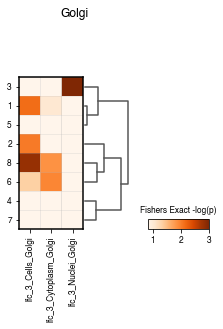

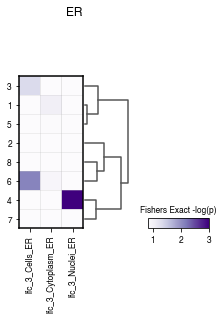

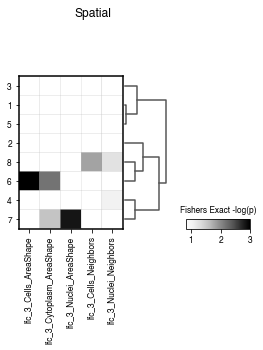

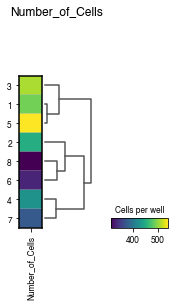

In [31]:
# figure out what makes the other clusters unique / enriched features
sc.tl.dendrogram(GT316, groupby = 'leiden', n_pcs=num_pcs, use_rep = 'X_pca_harmony', 
                 optimal_ordering=True, key_added='harmony_leiden', inplace=True)

adata = Feat_enrich_plot(GT316, 'GT316', vmax=3, lfc_cutoff=3)

### Cluster Enrichment Analysis

In [33]:
# generate enrichment table
GT316_enrich = fingerprint_shuffle_test(GT316, num_shuffle=100000)

In [34]:
# save metadata file with clusters for image pull
cols = ['Metadata_Plate', 'Metadata_Well', 'Metadata_Perturbation', 'leiden']
metadata = GT316.obs.loc[:,GT316.obs.columns.isin(cols)]
metadata.to_csv('GT316_metadata_image_pull.csv')

#### Define enriched perturbations

In [35]:
# Add mahalanobis calcs + Number of Cells into enrichment object
NumCells = GT316.obs.loc[:,GT316.obs.columns.isin(['Metadata_perturbation','Number_of_Cells','mahalanobis'])]
NumCells = NumCells.groupby('Metadata_perturbation').mean()
NumCells = GT316_enrich.obs.merge(NumCells, on='Metadata_perturbation', how='left')

GT316_enrich.obs['Number_of_Cells'] = NumCells.Number_of_Cells.values
GT316_enrich.obs['mahalanobis'] = NumCells.mahalanobis.values

In [50]:
# get set of sig perturbations
p_cutoff = 0.01
z_cutoff = 2

dmso_sig = (GT316_enrich.obsm['pval'][GT316_enrich.obs.Metadata_perturbation == 'DMSO'] < p_cutoff)

pert_sig = (GT316_enrich.obsm['pval'] < p_cutoff)&(GT316_enrich.X > z_cutoff)

fingerprint_sig_drugs = list(GT316_enrich.obs.Metadata_perturbation[np.sum(~dmso_sig*pert_sig, axis=1)>0])

multi_sig_drugs = list(GT316_enrich.obs.Metadata_perturbation[np.sum(~dmso_sig*pert_sig, axis=1)>1])

print('fingeprint enrichment finds ' +str(len(fingerprint_sig_drugs))+' significant drugs')
print('and ' +str(len(multi_sig_drugs))+' drugs enriched in >1 cluster')

fingeprint enrichment finds 66 significant drugs
and 0 drugs enriched in >1 cluster


Trying to set attribute `.obs` of view, copying.
... storing 'max_phenotype' as categorical


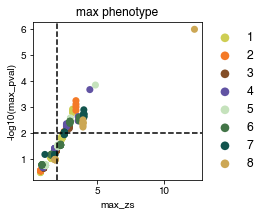

In [51]:
ax = sc.pl.scatter(GT316_enrich[GT316_enrich.obs.Metadata_perturbation!='DMSO'],
                   'max_zs', '-log10(max_pval)', color='max_phenotype', 
                   palette=cluster_colors, legend_fontsize=12, size=200, show=False)
ax.axhline(y= -np.log10(p_cutoff), ls='--', color='black');
ax.axvline(x= z_cutoff, ls='--', color='black');

fig = ax.figure
fig.set_figwidth(4)
fig.set_figheight(3)
fig.savefig('figures/GT316_phenotype_hit_plot.pdf')


In [52]:
# find compounds significant in both mahala + fingerprint
mahala_finger_sig = set(fingerprint_sig_drugs).intersection(mahala_sig_drugs)

print('overlapping drugs from fingerprint & Mahalanobis: '+str(len(mahala_finger_sig)))

overlapping drugs from fingerprint & Mahalanobis: 63


In [53]:
SGT_enrich = GT316_enrich[GT316_enrich.obs.Metadata_perturbation.isin(fingerprint_sig_drugs)]

#### Group significant perturbations

In [54]:
sc.pp.neighbors(SGT_enrich, n_neighbors=int(np.round(0.5*np.sqrt(np.shape(SGT_enrich.X)[0]))), use_rep = 'X')
sc.tl.umap(SGT_enrich)

In [55]:
SGT_enrich.obs.Metadata_perturbation = SGT_enrich.obs.Metadata_perturbation.astype('category')

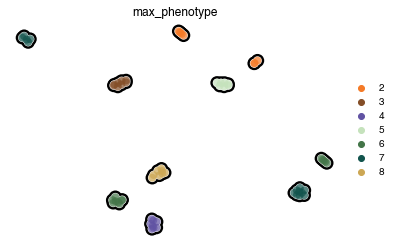

In [57]:
sc.pl.umap(SGT_enrich, color='max_phenotype', add_outline=True,frameon=False, size=250,
           palette=cluster_colors[1:8], save = 'GT316_enrich_sig_UMAP_max_pheno.pdf')

In [58]:
sc.tl.leiden(SGT_enrich, resolution = 0.7)

In [61]:
new_cluster_names = ['7-hi','6-8', '8', '3',
                     '4', '5', '7-lo',
                     '2-hi', '6', '2-lo']

new_cluster_order = ['2-lo', '2-hi', '3',
                     '4', '5', '6',
                     '6-8','7-lo','7-hi', '8']

SGT_enrich.rename_categories('leiden', new_cluster_names)
SGT_enrich.obs.leiden = SGT_enrich.obs.leiden.values.reorder_categories(new_cluster_order)

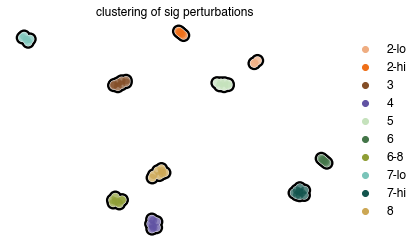

In [63]:
drug_cluster_colors = ['#EFAD81','#EF6F18',
                       '#844E27','#6153A3','#C5E2BC','#437548',
                       '#8F9E35',
                       '#7AC4B9','#12544D',
                       '#CCA754']

sc.pl.umap(SGT_enrich, color='leiden', add_outline=True,frameon=False, size=250,
           legend_fontsize=12,title='clustering of sig perturbations', 
           palette=drug_cluster_colors, save = 'GT316_enrich_sig_UMAP_perturbs.pdf')



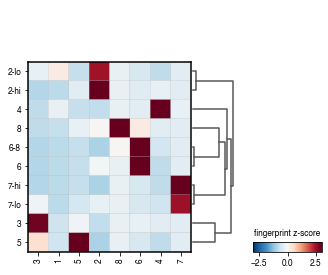

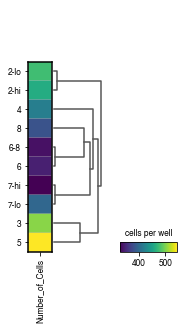

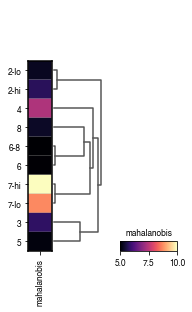

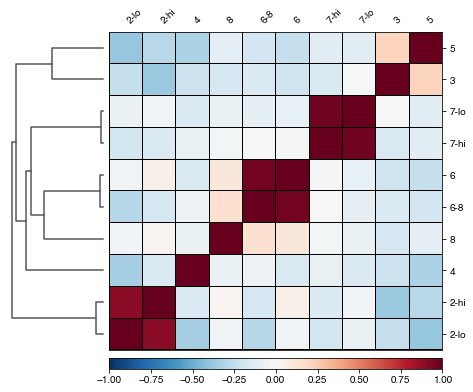

In [64]:


sc.tl.dendrogram(SGT_enrich, groupby = 'leiden', use_rep = 'X', 
                 optimal_ordering=True, key_added='zs_leiden', inplace=True)

sc.pl.matrixplot(SGT_enrich, ['3','1','5','2','8','6','4','7'], 'leiden', dendrogram='zs_leiden',
                 colorbar_title='fingerprint z-score', vmin=-3, vmax=3, cmap='RdBu_r', 
                 save='GT316_enrich_sig_pheno_corr.pdf')

sc.pl.matrixplot(SGT_enrich, ['Number_of_Cells'], 'leiden', dendrogram='zs_leiden',
                 colorbar_title='cells per well', cmap='viridis', 
                 save='GT316_enrich_sig_pheno_#cells.pdf')

sc.pl.matrixplot(SGT_enrich, ['mahalanobis'], 'leiden', dendrogram='zs_leiden',
                 colorbar_title='mahalanobis', cmap='magma', vmin=5, vmax=10,
                 save='GT316_enrich_sig_pheno_mahala.pdf')

sc.pl.correlation_matrix(SGT_enrich, groupby='leiden', dendrogram='zs_leiden', cmap='RdBu_r', save='GT316_enrich_drug_corr.pdf')

In [65]:
# save drug clustering
SGT_enrich.obs.loc[:,SGT_enrich.obs.columns.isin(['Metadata_perturbation','leiden'])].to_csv('GT316_drug_clusters.csv')


#### Re-plot on GT UMAP

In [66]:
# add sig clusters back to GT & OG adata
GT316 = fingers_to_adata(GT316, SGT_enrich)
OG316 = fingers_to_adata(OG316, SGT_enrich)

new_cluster_order = ['DMSO', '2-lo', '2-hi', '3',
                     '4', '5', '6',
                     '6-8','7-lo','7-hi', '8']

GT316.obs.sig_clusters = GT316.obs.sig_clusters.astype('category')
GT316.obs.sig_clusters = GT316.obs.sig_clusters.values.reorder_categories(new_cluster_order)

OG316.obs.sig_clusters = OG316.obs.sig_clusters.astype('category')
OG316.obs.sig_clusters = OG316.obs.sig_clusters.values.reorder_categories(new_cluster_order)

Trying to set attribute `.obs` of view, copying.


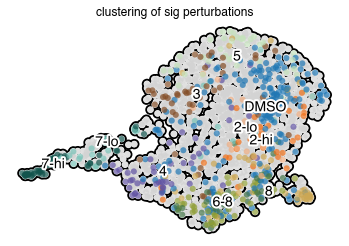

In [74]:
sc.pl.umap(GT316, color='sig_clusters', add_outline=True,
           frameon=False, size=150, na_in_legend=False,
           legend_loc='on data', legend_fontsize=14, legend_fontoutline=4,
           title='clustering of sig perturbations', 
           palette=['tab:blue']+drug_cluster_colors,
           save = 'GT316_UMAP_sig_drug_groups.pdf')

### Save anndatas

In [69]:
GT316.obs.signif_mahala = GT316.obs.signif_mahala.astype(str)

GT316.write('GT316_analyzed_anndata.h5ad')
OG316.write('OG316_analyzed_anndata.h5ad')
SGT_enrich.write('GT316_sig_enrich_anndata.h5ad')

... storing 'signif_mahala' as categorical
... storing 'landmarks' as categorical
... storing 'compartment' as categorical
... storing 'measure' as categorical
... storing 'channel' as categorical
